# Volatility Modelling


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import scipy.interpolate as interpolate
from scipy.stats import norm, ks_2samp, anderson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis


#### Data Preparation for Volatility Modelling

In [3]:
max_daily_dataset = nc.Dataset('../../datasets/tasmax_hadukgrid_uk_region_day_19600101-20211231.nc')
min_daily_dataset = nc.Dataset('../../datasets/tasmin_hadukgrid_uk_region_day_19600101-20211231.nc')
region = 10

def convert_hours_to_datetime(hours):
    base_date = datetime(1800, 1, 1, 0, 0, 0)  # Base date for the calculation
    delta = timedelta(hours=hours)  # Create a timedelta based on the hours
    # Add the timedelta to the base date to get the resulting datetime
    result_datetime = base_date + delta
    return result_datetime.date()

region_daily_min = min_daily_dataset['tasmin'][:, region]
region_daily_max = max_daily_dataset['tasmax'][:, region]
data_dict = {'min': region_daily_min, 'max': region_daily_max, 'time': min_daily_dataset['time'][:]}
df = pd.DataFrame(data=data_dict)
df['date'] = df['time'].apply(convert_hours_to_datetime)
df['avg'] = (df['min'] + df['max'])/2
pass



## Daily and monthly Volatility Modelling

First, we look at the monthly rolling volatility in our time series data

/tmp/ipykernel_94963/166740494.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


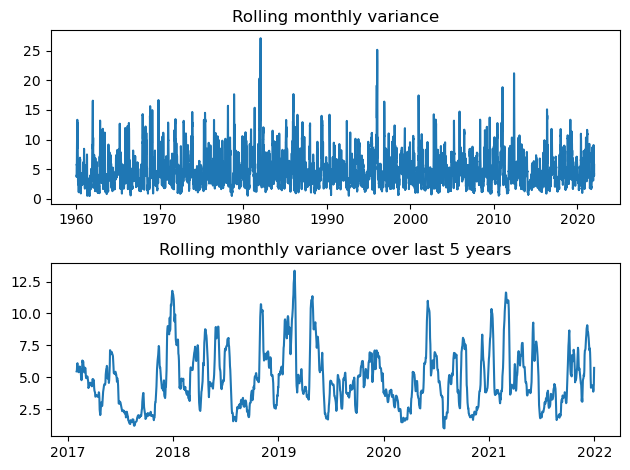

In [4]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(df['date'], df['avg'].rolling(window = 30).var())
axs[0].set_title("Rolling monthly variance")
axs[1].plot(df['date'][-365*5:], df['avg'][-365*5:].rolling(window = 30).var())
axs[1].set_title("Rolling monthly variance over last 5 years")
fig.tight_layout()
fig.show()

In [5]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract day and month from the 'date' column
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

# Group by day and month, and compute variance for each day
std_by_day = df.groupby(['month', 'day'])['avg'].std()
print(std_by_day)

month  day
1      1      2.927041
       2      2.881849
       3      2.593544
       4      2.552560
       5      2.788373
                ...   
12     27     3.399486
       28     3.652368
       29     3.669040
       30     3.366287
       31     3.165318
Name: avg, Length: 366, dtype: float64


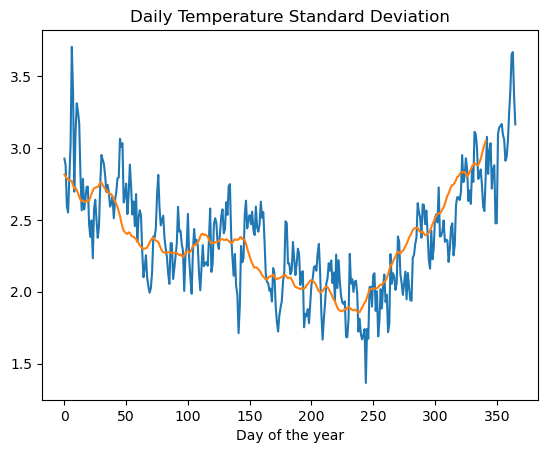

In [6]:
def moving_average(data, window_size):
    """Calculate the moving average of a 1D numpy array."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


plt.plot(std_by_day.values)
plt.plot(moving_average(std_by_day.values, 25))
plt.title("Daily Temperature Standard Deviation")
plt.xlabel("Day of the year")
plt.show()

# Model Comparison Metrics

Ideally, I would use a likelihood based metric such as the Akaike Information and Bayesian Information Criterons to compare model suitability. The Akaike Information Criteron is given by,

$$ AIC = - 2 \log \hat{L} - 2k $$

Where $\hat{L}$ is the likelihood function of the training data under the model and $k$ is the number of parameters in the model, a regularising term.

Similarly, the Bayesian Information Criteron is given by,

$$ BIIC = - 2 \log \hat{L} - k \cdot \log n $$

In this model, the regularisation term is not multiplied by a constant but instead by the logarthim of the number of data points in the model. Scaling by the number of training points instead of a constant is subtle however as models with more data are more prone to overfitting, scaling the regularisation penalises larger models attempting to fit more data. It also ensures the score of a model is invariant of the dataset size.  

Unfortunately, in fitting the trend a single prediction is outputted for each input, therefore I cannot use likelihood based metrics as there is no probability distribution produced by my outputs, effectively our models gives a Kronker delta for the trend at each point. Therefore, I will modify these metric to depend on the RSS instead.

In [7]:
def AIC_RSS(y_pred, y_true, k_parameters):
    return 2 * ((y_pred - y_true)**2).sum() + 2 * k_parameters 

def BIC_RSS(y_pred, y_true, k_parameters):
    return ((y_pred - y_true)**2).sum() + np.log(len(y_pred)) * k_parameters 

## Piecewise Modelling

Our first simple model will be fitting a piecewise constant function to each month of the year.

Month 1 average standard deviation: 2.7763002417809917
Month 2 average standard deviation: 2.713507633203285
Month 3 average standard deviation: 2.3146612343794626
Month 4 average standard deviation: 2.2733487675745825
Month 5 average standard deviation: 2.375743823973072
Month 6 average standard deviation: 2.211228659500156
Month 7 average standard deviation: 2.0624116896451805
Month 8 average standard deviation: 1.973711600351153
Month 9 average standard deviation: 1.9786444518128625
Month 10 average standard deviation: 2.3254938100930382
Month 11 average standard deviation: 2.6240833015672775
Month 12 average standard deviation: 2.986426498518974


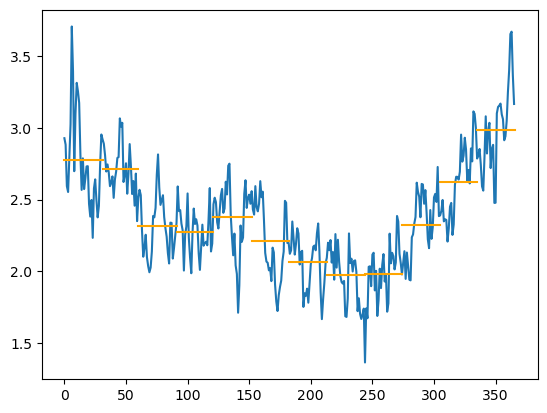

In [8]:
monthly_means = np.zeros(12, dtype=np.float64)
fig, axs = plt.subplots(1)
axs.plot(std_by_day.values)
piecewise_preds = np.empty(len(std_by_day.values))
day = 0

for i in range(12):
    month = i + 1
    monthly_means[i] = np.mean(std_by_day[month].values)
    print(f"Month {month} average standard deviation: {monthly_means[i]}")
    newday = day + len(std_by_day[month].values)
    piecewise_preds[day:newday] = monthly_means[i]
    axs.plot([day, newday], [monthly_means[i], monthly_means[i]], color='orange')
    day = newday    

In [9]:
print(f"AIC_RSS: {AIC_RSS(piecewise_preds, std_by_day.values, 12)}")
print(f"BIC_RSS: {BIC_RSS(piecewise_preds, std_by_day.values, 12)}")

AIC_RSS: 63.034736647996425
BIC_RSS: 90.3489683248146


## Parameteric Regression

/tmp/ipykernel_94963/3291774492.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


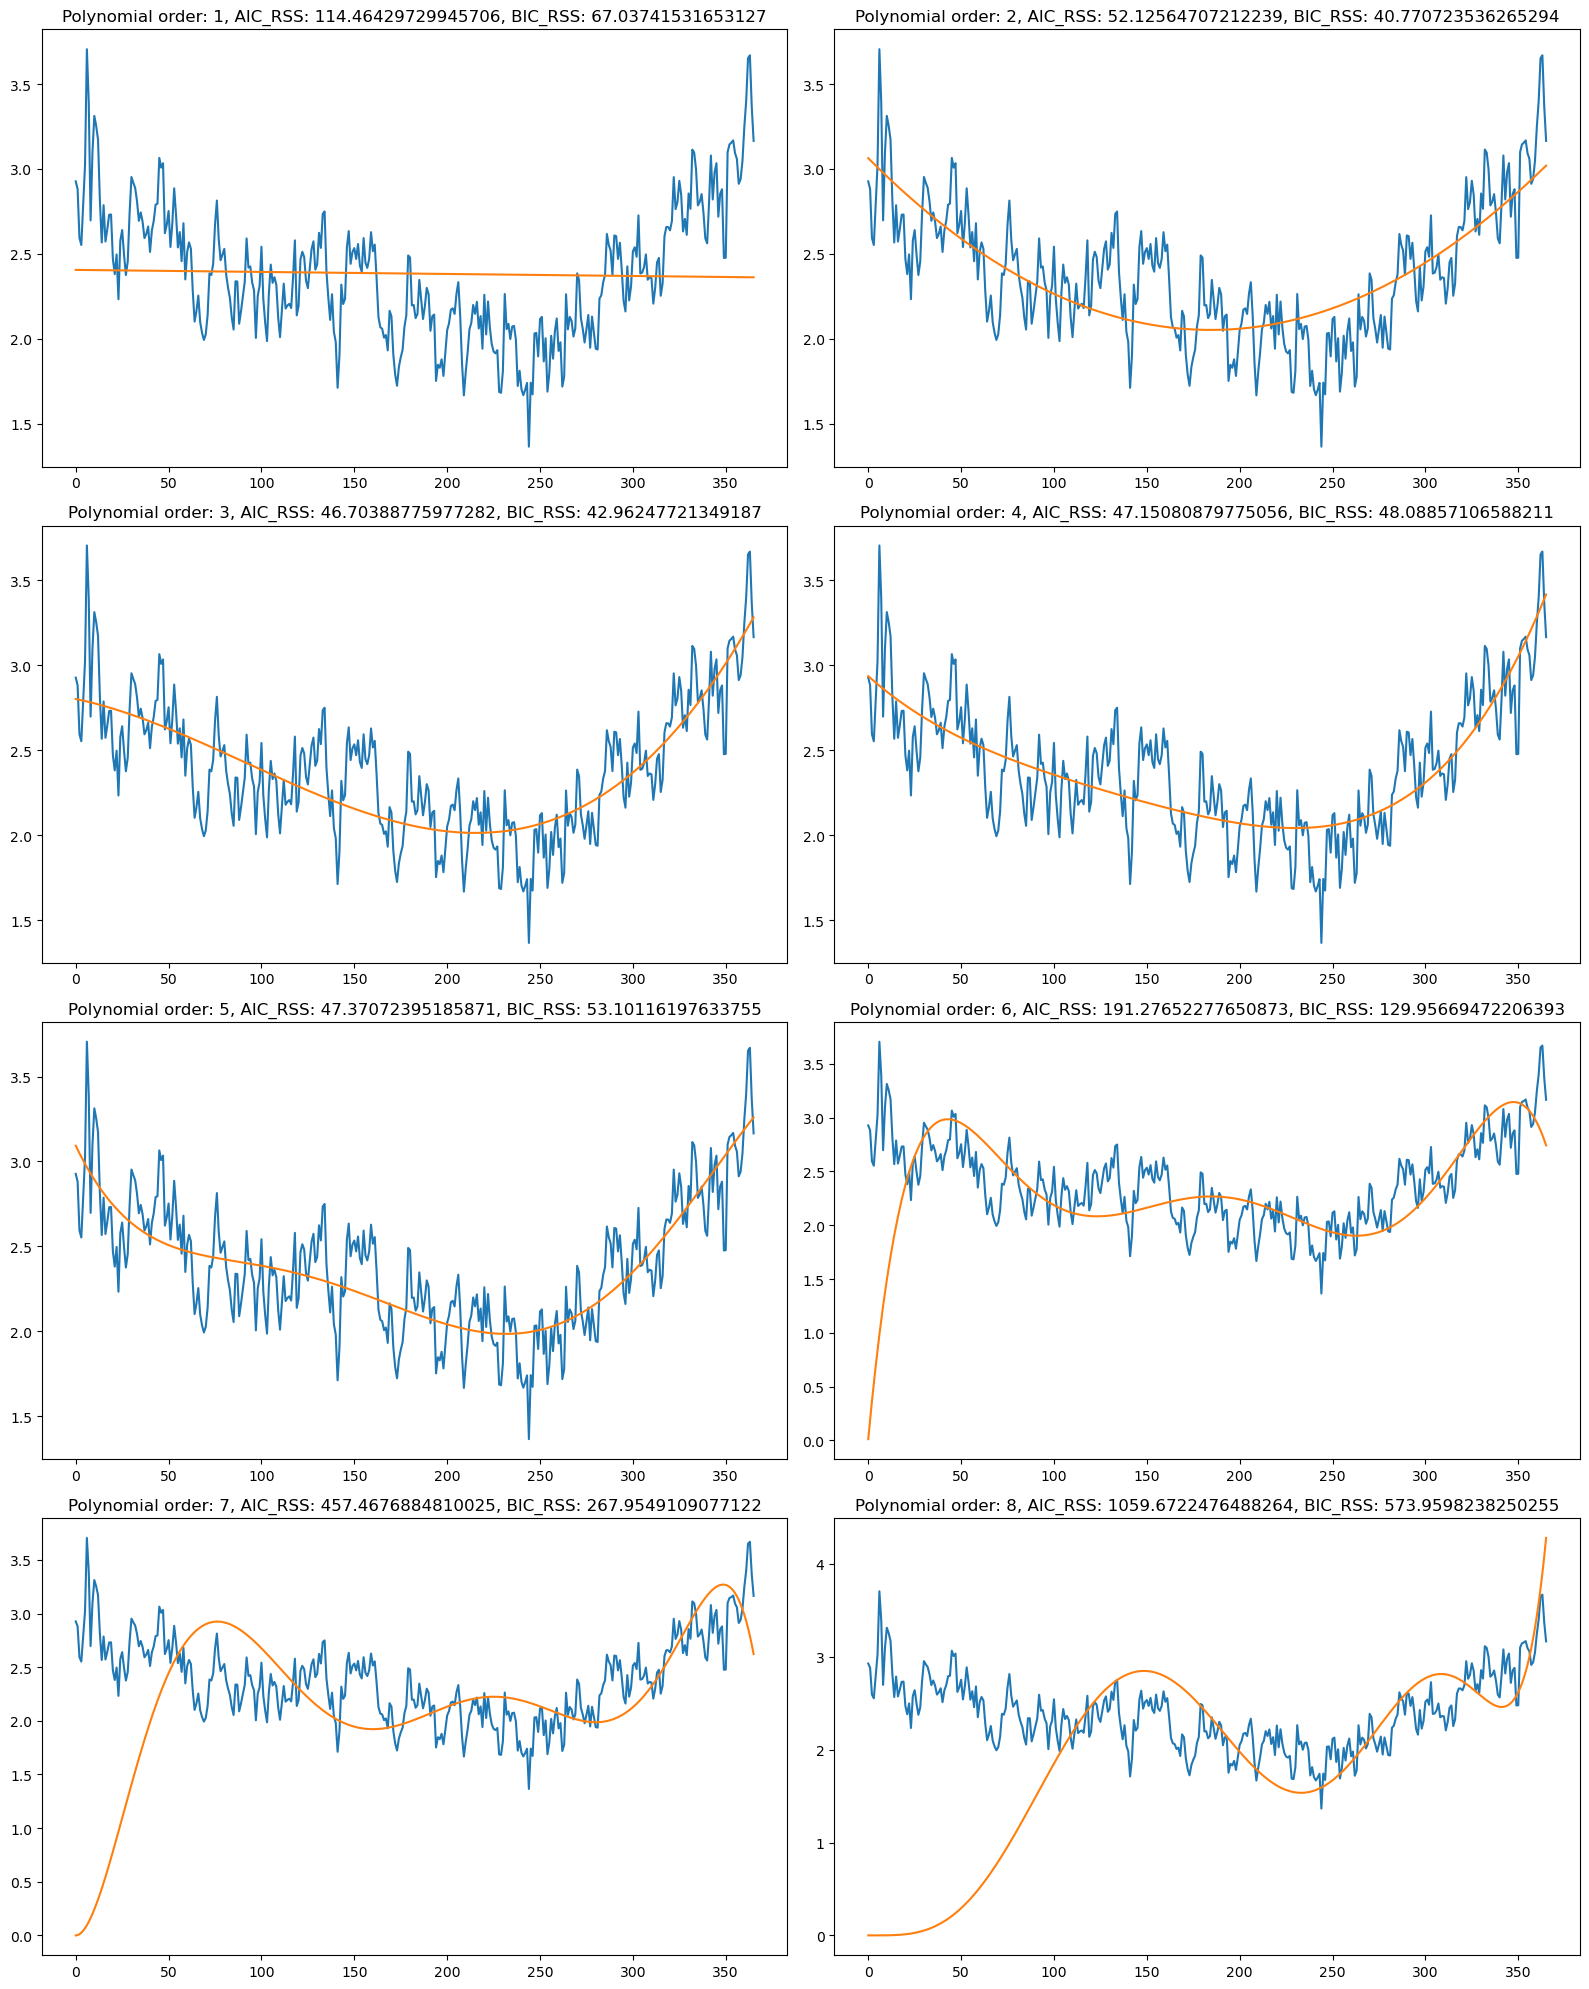

In [10]:
x = np.array(np.arange(len(std_by_day.values.flatten())))
y = np.array(std_by_day.values.flatten())

# Degrees of polynomial
polynomial_degrees = np.arange(1, 9, dtype=np.int16)

fig, axs = plt.subplots(4, 2, figsize=(16, 20))

def polynomial_regression_fit(degree, x, y):
    x= x[:,np.newaxis]
    y= y[:,np.newaxis]
    poly_feats = PolynomialFeatures(degree=degree)
    transform = poly_feats.fit_transform(x)
    model = sm.OLS(y, transform).fit()
    predictions = model.predict(transform)
    return model, predictions

def polynomial_regression(degree, x, y):
    _model, predictions = polynomial_regression_fit(degree, x, y)
    return predictions

for degree in polynomial_degrees:
    predictions = polynomial_regression(degree, x, y)
    axs[int((degree - 1) / 2), (degree + 1) % 2 ].plot(y)
    axs[int((degree - 1) / 2), (degree + 1) % 2 ].plot(predictions)
    axs[int((degree - 1) / 2), (degree + 1) % 2 ].set_title(f"Polynomial order: {degree}, AIC_RSS: {AIC_RSS(predictions, y, degree + 1)}, BIC_RSS: {BIC_RSS(predictions, y, degree + 1)}")
fig.tight_layout()
fig.show()


## Fourier Series Volatility Modelling



We use the numpy fast fourier series function to calculate the fourier coefficients of the series. These are given analytically by, 

$$ c_{k} = \int_{0}^{1} f(x)e^{-2\pi i k x} dx$$

The inverse fourier transform is then used to reconstruct the signal using these terms, the formula for the reconstructed sequence is given by:

$$ f(x) = \sum_{k=-N}^{N} c_{k} e^{2\pi i k x} $$

/tmp/ipykernel_94963/1005823297.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


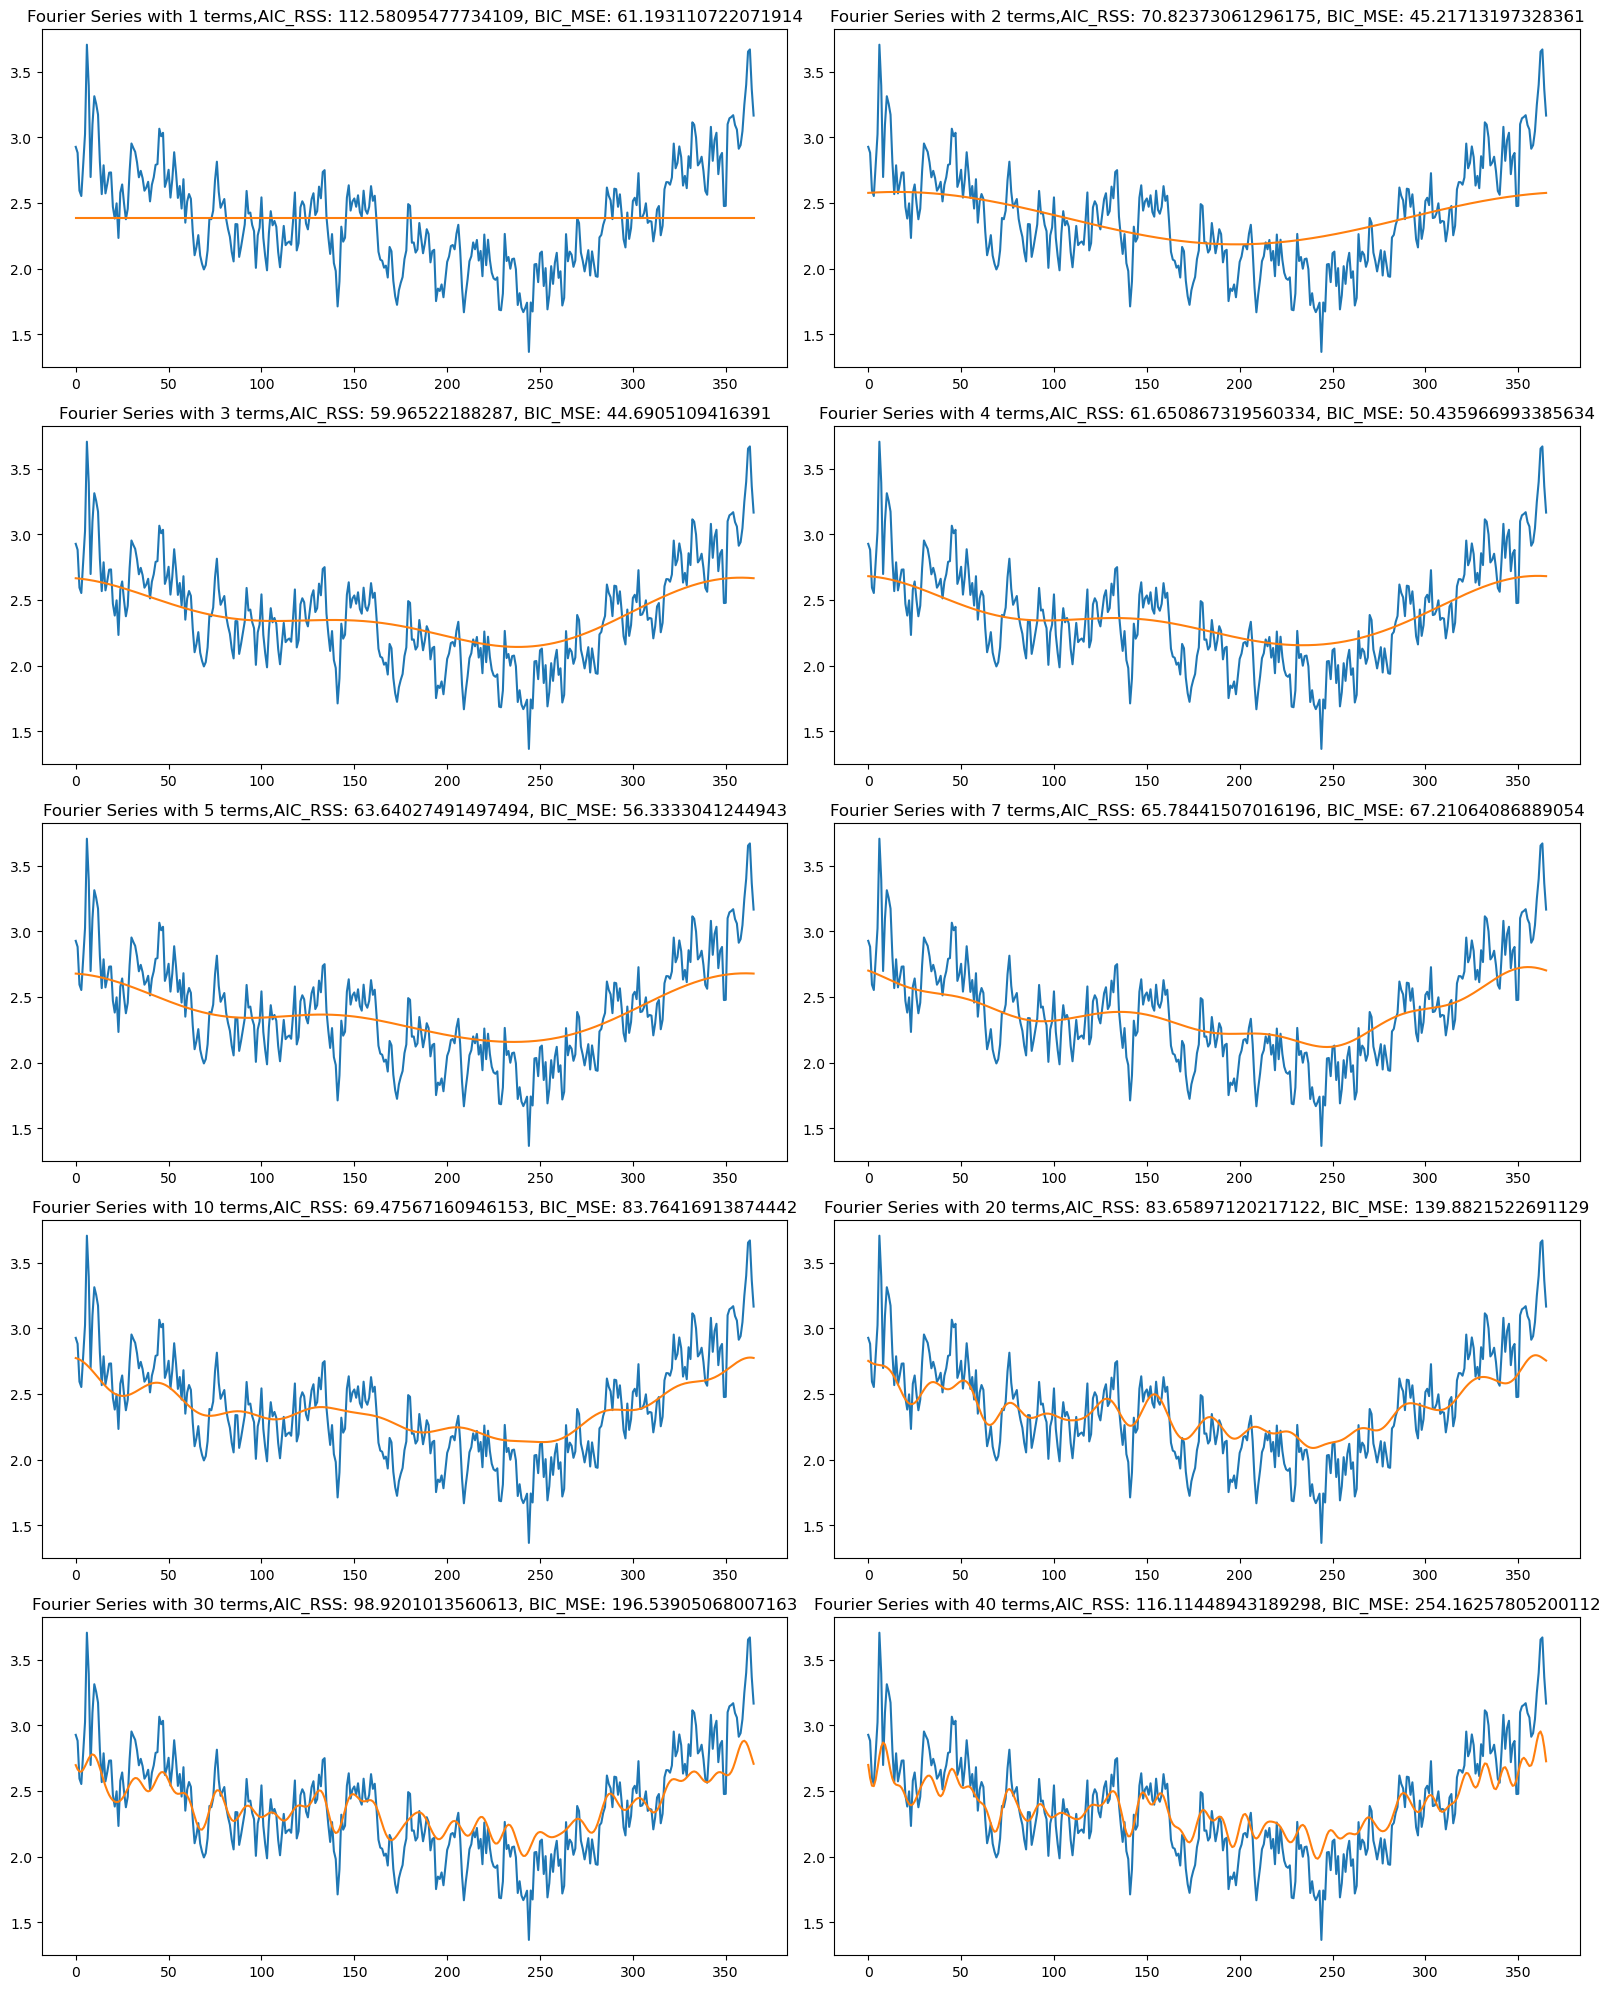

In [11]:
x = np.arange(0, 366)
y = np.array(std_by_day.values.flatten())

 # Number of terms in the Fourier series
fourier_terms = np.array([1, 2, 3, 4, 5, 7, 10, 20, 30, 40])
fourier_coeffs = np.fft.fft(y) / len(y)

def fourier_series(x, coeffs, n_terms):
    y_reconstructed = np.zeros_like(x, dtype=complex)
    for k in range(n_terms):
        y_reconstructed += coeffs[k] * np.exp(2j * np.pi * k * x / 365.25)
    return y_reconstructed.real

fig, axs = plt.subplots(5, 2, figsize=(16, 20))
for fourier_index, fourier_term in enumerate(fourier_terms):
    predictions = fourier_series(x, fourier_coeffs, fourier_term)
    axs[int(fourier_index / 2), fourier_index % 2].plot(y)
    axs[int(fourier_index / 2), fourier_index % 2].plot(predictions)
    axs[int(fourier_index / 2), fourier_index % 2].set_title(f"Fourier Series with {fourier_term} terms,AIC_RSS: {AIC_RSS(predictions, y, fourier_term)}, BIC_MSE: {BIC_RSS(predictions, y, fourier_term)}")
    
fig.tight_layout()
fig.show()

## Splines



Splines model functions by interpolating between so-called `knots', which are points lying on the tangents between data points. These curves are $\mathbf{C}^{2}$ continuous. The number of knots is a hyper-parameter of the model. I will be using cubic splines to interpolate between knots, a higher degree corresponds to a smoother curve, however this is at the expense of more computation.

In the `scipy.interpolate.splrep` (spline representation) function by default cubics are used to interpolate between knots. The learnable parameters are given by `c` and therefore the number of learnable parameters (a proxy for model complexity) is given by `len(c)`. 

/tmp/ipykernel_94963/3351486271.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


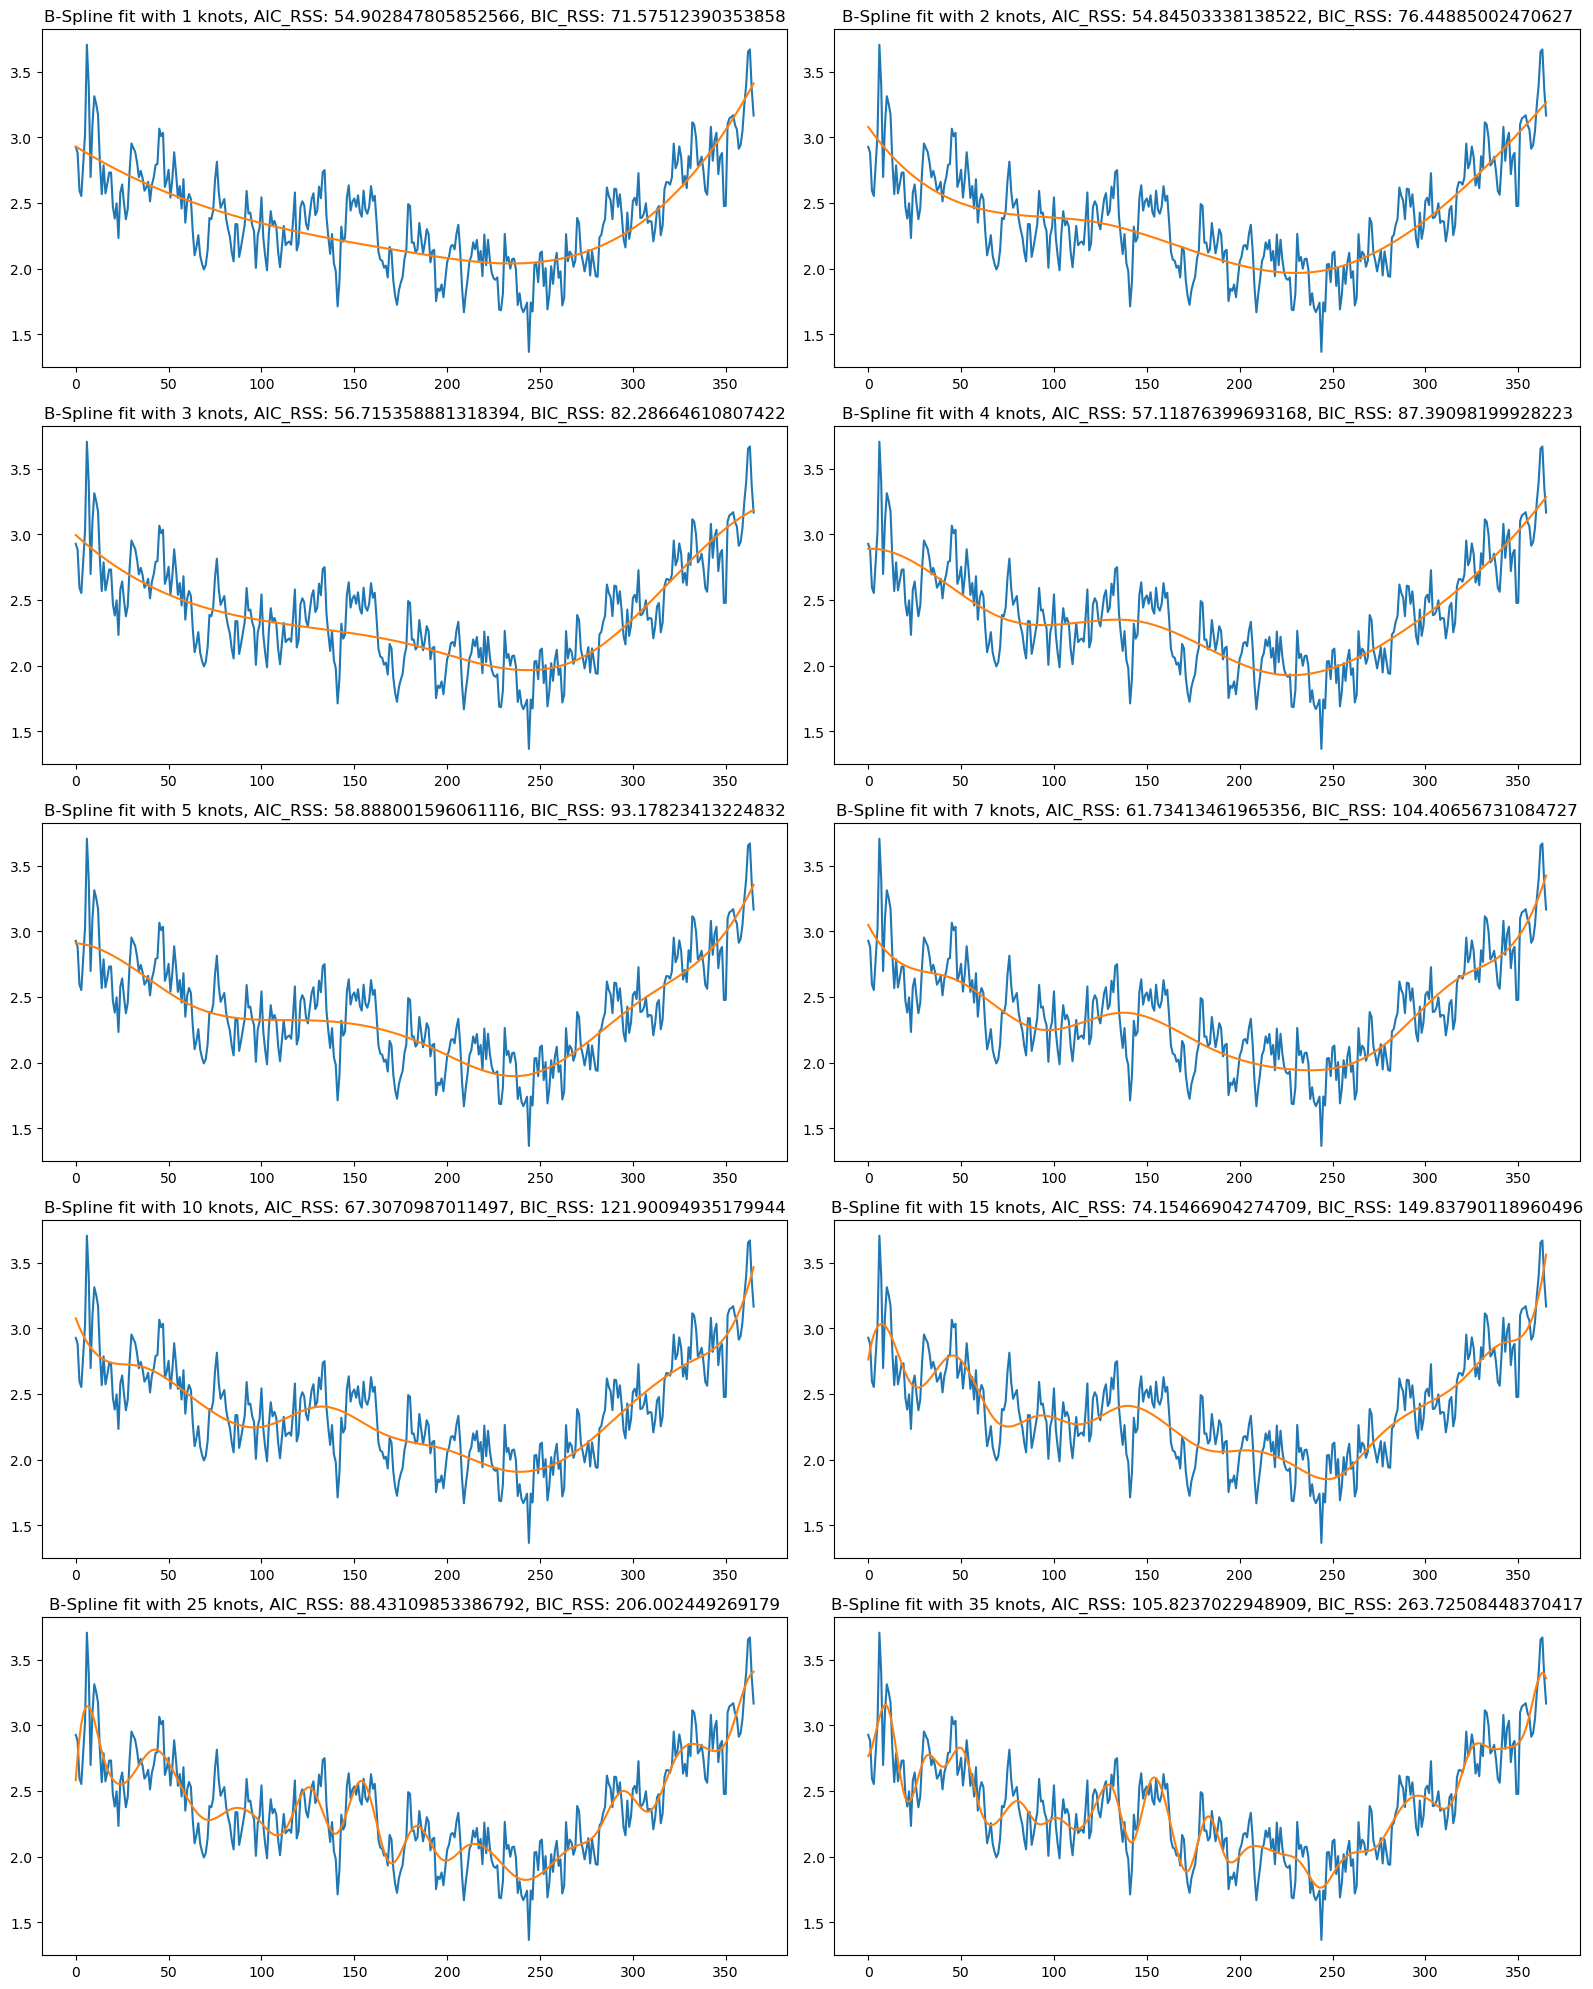

In [12]:
knot_numbers = np.array([1, 2, 3, 4, 5, 7, 10, 15, 25, 35])

def spline_fit(x, y, no_knots):
    x_new = np.linspace(0, 1, no_knots+2)[1:-1]
    q_knots = np.quantile(x, x_new) 
    t,c,k = interpolate.splrep(x, y, t=q_knots, s=1)
    return interpolate.BSpline(t,c,k)(x), len(c)

fig, axs = plt.subplots(5, 2, figsize=(16, 20))
for knot_index, knot in enumerate(knot_numbers):
    predictions, no_learnable_parameters = spline_fit(x, y, knot)
    axs[int(knot_index / 2), knot_index % 2].plot(y)
    axs[int(knot_index / 2), knot_index % 2].plot(predictions)
    axs[int(knot_index / 2), knot_index % 2].set_title(f"B-Spline fit with {knot} knots, AIC_RSS: {AIC_RSS(y, predictions, no_learnable_parameters)}, BIC_RSS: {BIC_RSS(y, predictions, no_learnable_parameters)}")
    
fig.tight_layout()
fig.show()

## Chosen Volatility Model

We summarise the results in the table below;

| Model | AIC_RSS | BIC_RSS |
|---------|---------|---------|
| Piecewise | 63.035 | 90.349 |
| Polynomial (Degree 2) | 52.126 | 40.771 |
| Polynormail (Degree 3) | 46.704 | 42.962 |
| Fourier Series, 3 Terms | 59.965 | 71.673 |
| B-Spline (1-Knot) | 54.903 | 71.575 |

We see the fourier series, while being the only continuous function $\left( \underset{t \to 0^{+}}{\lim} f(t) = \underset{t \to 365^{-}}{\lim} f(t)\right)$ the discrepancy between volatilities at early in the year and late in the year means this continuity is lost on all other models.

[ 2.80131071e+00 -2.28205148e-03 -2.98096364e-05  1.08681681e-07]


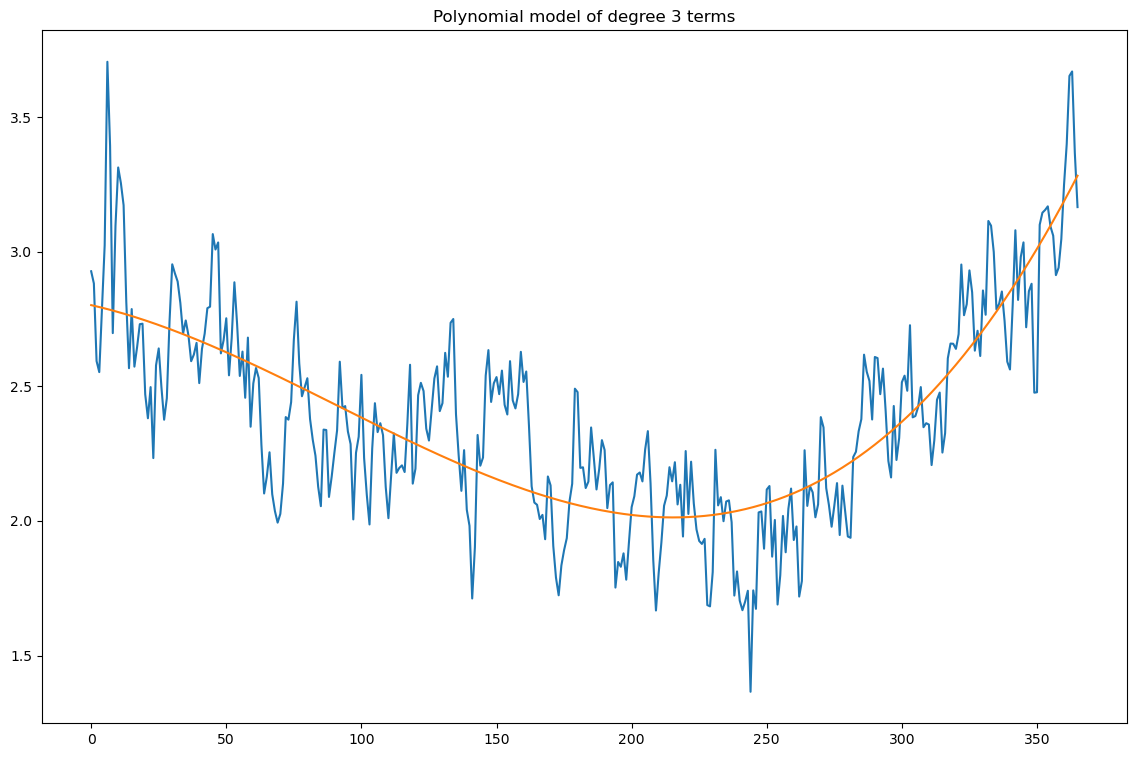

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(14, 9))
# y_model = fourier_series(x, fourier_coeffs, 3)
y_model, y_predictions = polynomial_regression_fit(3, x, y)
axs.plot(y, label="Volatilities")
axs.plot(y_predictions, label="Model")
axs.set_title(f"Polynomial model of degree {3} terms")
print(y_model.params)

In [14]:
def sigma_derivative(params, x):
    powers = np.arange(1, len(params))  # 1 to len(params)-1
    return np.dot(np.power.outer(x, powers-1), powers * params[1:])

In [15]:
def poly_model(params, x):
    powers = np.arange(len(params))
    return np.dot(np.power.outer(x, powers), params)

## Skew and Kurtosis

### Skew

The skewness of a dataset or distribution is the measure of its symmetry (or asymmetry). The skewness of a random variable $X \sim p_{X}$ is given by the quantity 

$$ \text{Skewness: } \gamma = \mathbb{E}_{p_{X}} \left[ \left(\frac{X - \mu}{\sigma} \right)^{3} \right] $$

The reason why this represents skewness in a distribution is because: the quantity $\left(\frac{X - \mu}{\sigma} \right)$ represents how many standard deviations the data is around the mean. Upon cubing these quantity, the sign of the value is preserved however the magnitude of values within one standard deviation is diminished and the magnitude of values above one standard deviation is increased. For symmetric diistributions the positive and negative contributions around the mean will cancel, resulting in $0$ skewness. For skewed, asymmetric, distributions, there will be greater contributions from one side of the mean resulting in a non-zero, directional skew. 

### Kurtosis

Kurtosis measures the "tailed-ness" or the sharpness of the peak of the distribution. The Kurtosis of the normal distribution (of arbitrary parameters) is $3$. Therefore, $3$ is often subtracted from the Kurtosis to give a statistic relative to the Kurtosis, tailed-ness, of the normal distribution.

- A kurtosis close to 0 indicates a distribution that is relatively similar to the normal distribution in terms of its tails and peak.
- A positive kurtosis indicates a distribution with heavier tails and a sharper peak than the normal distribution.
- A negative kurtosis indicates a distribution with lighter tails and a less sharp peak than the normal distribution.

$$ \text{Kurtosis: } \kappa = \frac{\mathbb{E}\left[(X - \mu)^{4}\right]}{\mathbb{E}\left[(X - \mu)^{2} \right]^{2}} = \mathbb{E}\left[\left( \frac{X - \mu}{\sigma}\right)^{4} \right]. $$

This quantity can be interpreted as an average over the fourth power standardised distribution. For data points within one standard deviation of the mean the standardised statistic is less than one. Upon raising this to the fourth power the contribution of the standardised values in this domain are minimal. Therefore the Kurtosis effectively measures how much of the distribution is outside of one standard deviation from the mean. 

In [16]:
vol_residuals = y - y_predictions

print(f"Mean of residuals of residuals: {np.mean(vol_residuals)}")
print(f"Standard deviation of residuals: {np.std(vol_residuals)}")
print(f"Skewness of residuals: {skew(vol_residuals)}")
print(f"Kurtosis of residuals: {kurtosis(vol_residuals)}")

Mean of residuals of residuals: 1.0497384989190519e-11
Standard deviation of residuals: 0.22994382706706223
Skewness of residuals: 0.16569367397639861
Kurtosis of residuals: 0.30315890490716635


/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/tmp/ipykernel_94963/540982911.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


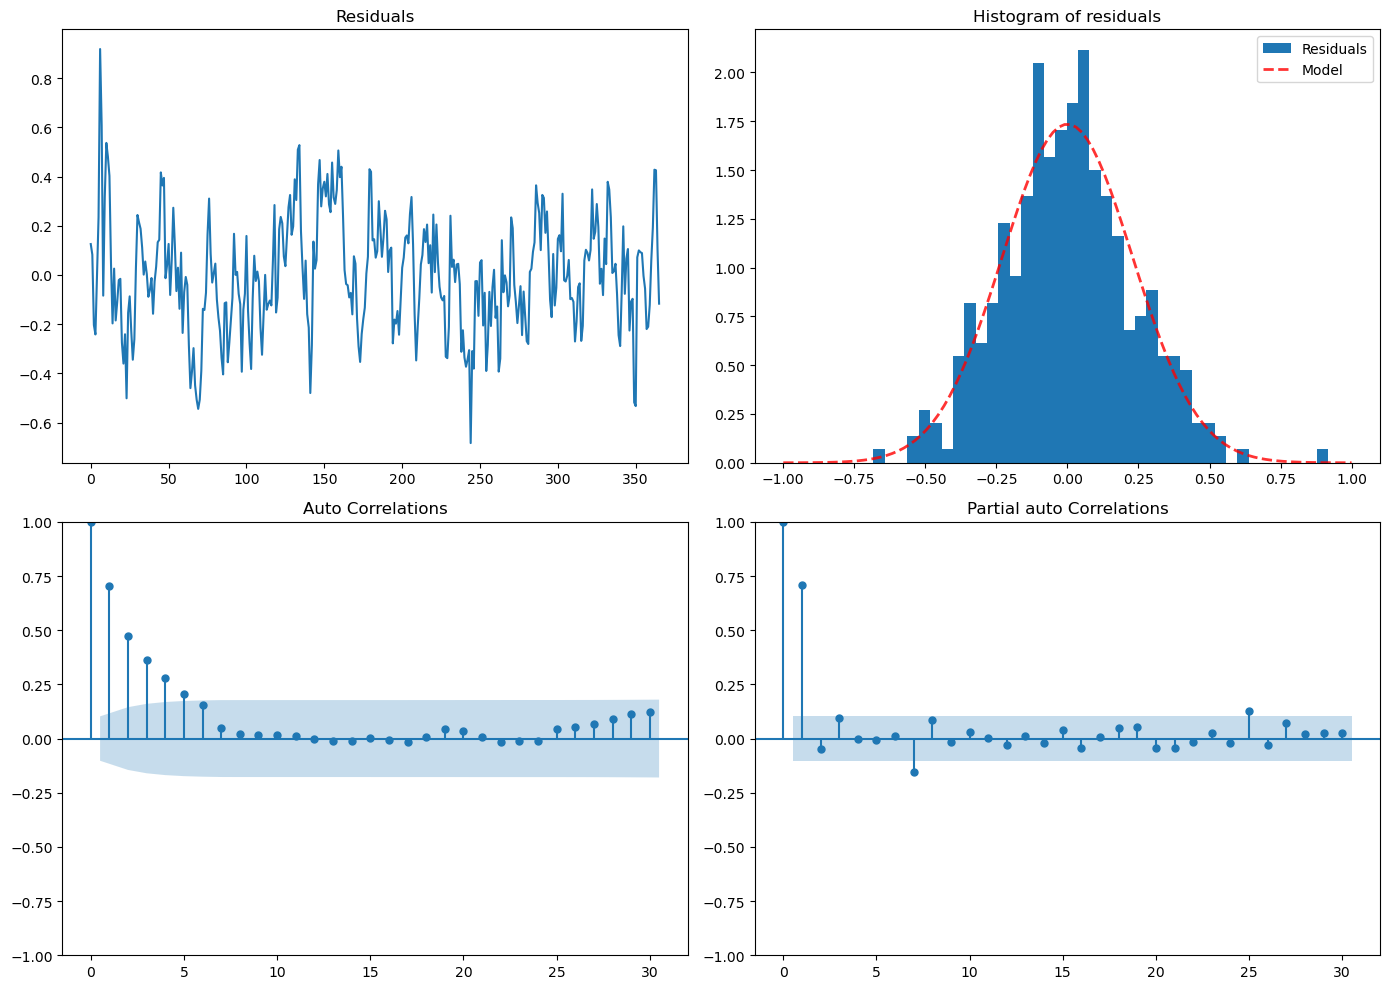

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].plot(x, vol_residuals)
axs[0, 0].set_title("Residuals")

axs[0, 1].hist(vol_residuals, bins=40, stacked=True, density=True, label="Residuals")
p = norm.pdf(np.linspace(-1.0, 1.0, 100), np.mean(vol_residuals), np.std(vol_residuals))
axs[0, 1].plot(np.linspace(-1.0, 1.0, 100), p, 'r', alpha=0.8, linestyle='--', linewidth=2, label="Model")
axs[0, 1].set_title("Histogram of residuals")
axs[0, 1].legend()

plot_acf(vol_residuals, lags=30, ax=axs[1, 0])
axs[1, 0].set_title("Auto Correlations")

plot_pacf(vol_residuals, lags=30, ax=axs[1, 1])
axs[1, 1].set_title("Partial auto Correlations")

fig.tight_layout()
fig.show()

## Now we aim to model the volatility of the volatility, $\chi$

First we check if the distribution of residuals this is Gaussian, if so we can use a constant to model to dispersion of volatilities around the annual trend we have modelled above.

## Kolmogorov-Smirnov and Anderson-Darling Tests

### Kolmogorov-Smirnov Test

The Kolmogorov-Smirnov test is a nonparametric test which determines if two datasets come from a particular theoretical distribution. The K-S test quantifies the distance between the empirical distribution function (EDF) of the samples and the cumulative distribution function (CDF) of the reference distribution or between the EDFs of two samples.

The test statistic is the maximum absolute difference between the EDF and the CDF:
$$ \text{K-S test statistic: } D = \underset{x \in \text{Samples}}{\max} |F_{n}(x) - F(x)| $$


In [18]:
D, p_value = ks_2samp(vol_residuals, np.random.normal(0, np.std(vol_residuals), 1000))

print(f"D-statistic: {D}")
print(f"P-value: {p_value}")

if p_value > 0.99:
    print("Two samples seem to be drawn from the same distribution (fail to reject H0)")
else:
    print("Two samples seem to be drawn from different distributions (reject H0)")

D-statistic: 0.03891803278688524
P-value: 0.7934369059442109
Two samples seem to be drawn from different distributions (reject H0)


### Anderson-Darling Test



In [19]:
standardized_vol_residuals = vol_residuals / np.std(vol_residuals)

# Perform Anderson-Darling test for normality on the standardized data
result = anderson(standardized_vol_residuals)

print(f'Anderson-Darling Statistic: {result.statistic}')

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'At {sl}% significance level, data looks normal (fail to reject H0)')
    else:
        print(f'At {sl}% significance level, data does not look normal (reject H0)')


Anderson-Darling Statistic: 0.2946336256512154
At 15.0% significance level, data looks normal (fail to reject H0)
At 10.0% significance level, data looks normal (fail to reject H0)
At 5.0% significance level, data looks normal (fail to reject H0)
At 2.5% significance level, data looks normal (fail to reject H0)
At 1.0% significance level, data looks normal (fail to reject H0)


Therefore, it appears the residuals of the volatility are Gaussian.

## Final model of the volatility

$$ dS_{t} =  \left(\dot{\sigma}(t) + \alpha_{2}(\sigma(t) - S_{t}) \right) dt + \chi dW_{t} $$

As reasoned previously, we can find a value of $\alpha_{2}$ by fitting an AR-1 model to the residuals.

## Modelling the rate of mean reversion, $\alpha_{2}$

We can model the speed of reversion by first considering the AR(1) process. 

$$ S_{t} = w + \theta S_{t-1} + \epsilon_{t}$$

The Ornsten-Ulhenbeck process can be interpreted as a continuous time analogue of the residuals of the AR(1) process.

Considering the Euler-Maryuama discretisation of our modified OU process over the interval $t\in[i-1, i]$, we find:

\begin{align*}
    dS_{t} = S_{i} - S_{i-1} &= \sigma(i) - \sigma(i-1) + \alpha\left(\sigma_{i-1} - S_{i-1}\right) + \chi dW_{1} \\
    S_{i} - \sigma(t_{i}) &= S_{i-1} - \sigma({i-1}) + \alpha_{2} \left(\sigma(i-1)-S_{i-1}\right) + \chi dW_{1} \\
    R_{i} &= R_{i-1} \left(1 - \alpha_{2} \right) + \epsilon_{i} 
\end{align*}

Which is an AR(1) model of the residuals. As we saw from the partial auto correlation of our residuals and AR(1) model is appropriate for modelling the residuals. Therefore, we find that $1 - \alpha_{2} = \theta$ in the AR(1) model of the residuals. This is how we can determine the rate of mean reversion, $\alpha_{2}$.

In [20]:
model_fit = sm.tsa.AutoReg(vol_residuals, lags=1, old_names=True,trend='n').fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  366
Model:                     AutoReg(1)   Log Likelihood                 144.545
Method:               Conditional MLE   S.D. of innovations              0.163
Date:                Fri, 08 Sep 2023   AIC                           -285.090
Time:                        12:33:09   BIC                           -277.290
Sample:                             1   HQIC                          -281.991
                                  366                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.7067      0.037     19.083      0.000       0.634       0.779
                                    Roots                                    
                  Real          Imaginary           M

/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(


## Final SDE model for temperature:

Finally, we can present our model for temperature modelling:

$$ \left( \begin{array}{c} dT_t \\ dS_{t} \\ \end{array} \right) = \left( \begin{array}{c} \dot{\mu}(t) + \alpha_{1}(\mu(t) - T_{t}) \\ \dot{\sigma}(t) + \alpha_{2}(\sigma(t) - S_{t}) \\ \end{array} \right) dt + \left( \begin{array}{c} S_{t} & 0 \\ 0 & \chi \\ \end{array} \right) \left( \begin{array}{c} dW^{(1)}_{t} \\ dW^{(2)}_{t} \\ \end{array} \right)$$

### Heston Model

This is somewhat similar to the Heston model, which is the following for asset pricing, with stochastic volatility. Presented by Steven Heston [1] in 1993, it assumes the asset follows Geometric Brownian motion dynamics with a stochastic volatilty.

Asset Price Dynamics:
$$ dS_t = r S_t dt + \sqrt{v_t} S_t dW^{S_{t}}$$ 
 
Where:
- $S_{t}$ is the asset price at time $t$.
- $r$ is the risk-free rate.
- $\sqrt{v_t}$ is the volatility of the asset price.
- $dW^S_t$ is a standard Wiener process (Brownian motion) for the asset price.

Variance Dynamics:
$$ dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^{v_{t}} $$ 
Where:
- $v_t$ is the variance of the asset price at time $t$.
- $\kappa$ is the rate at which $v_{t}$ reverts to its long-term mean, $\theta$.
- $\theta$ is the long-term mean variance.
- $\sigma$ is the volatility of volatility, which quantifies how much the variance $v_t$ fluctuates around its mean.
- $dW^{v_{t}}$ is a standard Wiener process for the variance.

Additionally, the two Brownian motions $dW^{S_{t}}$ and $dW^{v_{t}}$ are correlated, with a correlation coefficient $\rho$. This means:
$$dW^S_t \cdot dW^v_t = \rho dt.$$ 

The correlation between the random increments of the underlying volatility and asset price encode a historical empirical relation into the model, by which stock returns and changes in volatility have been observed to be negatively correlated.

This can be summarised in the following:
$$
\begin{align*}
\begin{pmatrix}
    dS_t \\
    dv_t
\end{pmatrix}
&=
\begin{pmatrix}
    r S_t \\
    \kappa (\theta - v_t)
\end{pmatrix}
dt 
+
\begin{pmatrix}
    \sqrt{v_t} S_t & 0 \\
    \rho \sigma \sqrt{v_t} & \sigma \sqrt{v_t}
\end{pmatrix}
\begin{pmatrix}
    dW^S_t \\
    dW^v_t
\end{pmatrix}
\end{align*}
$$

In this representation, $dW^{S_t}$ and $dW^{v_t}$ are independent Brownian increments. The Heston model is solved using Fourier Transforms and characteristic functions. These quantities are related as follows:

#### Fourier Transform

Given a function $f(t)$, or signal, of time $t$. The fourier transform is given by, 

$$F(w) := \int_{-\infty}^{\infty} f(t) e^{-i w t} dt = \int_{-\infty}^{\infty} f(t) \left(\cos(w t) - i \sin(w t)\right) dt.$$

To interpret this quantity, if $f(t)$ has a strong component at the frequency $w$, then the product $f(t)e^{-i w t}$ will be large and positive for one side of the sinusodial period and large and negative for the other side. If the signal has little frequency of $w$ then the product $f(t) e ^{-i w t}$ will oscillate inconsistently and the resulting integral will be small. The real and imaginary parts of $F(w)$ can be interpreted as a "correlation" or alignedness of the function and cosine and sine components respectively. 

For example, lets consider the function $f(x) = \cos(2 \pi t)$ and a variety of frequencies $w$.

/tmp/ipykernel_140860/4254322590.py:48: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[4, 1].stem(ws, F_values, use_line_collection=True)


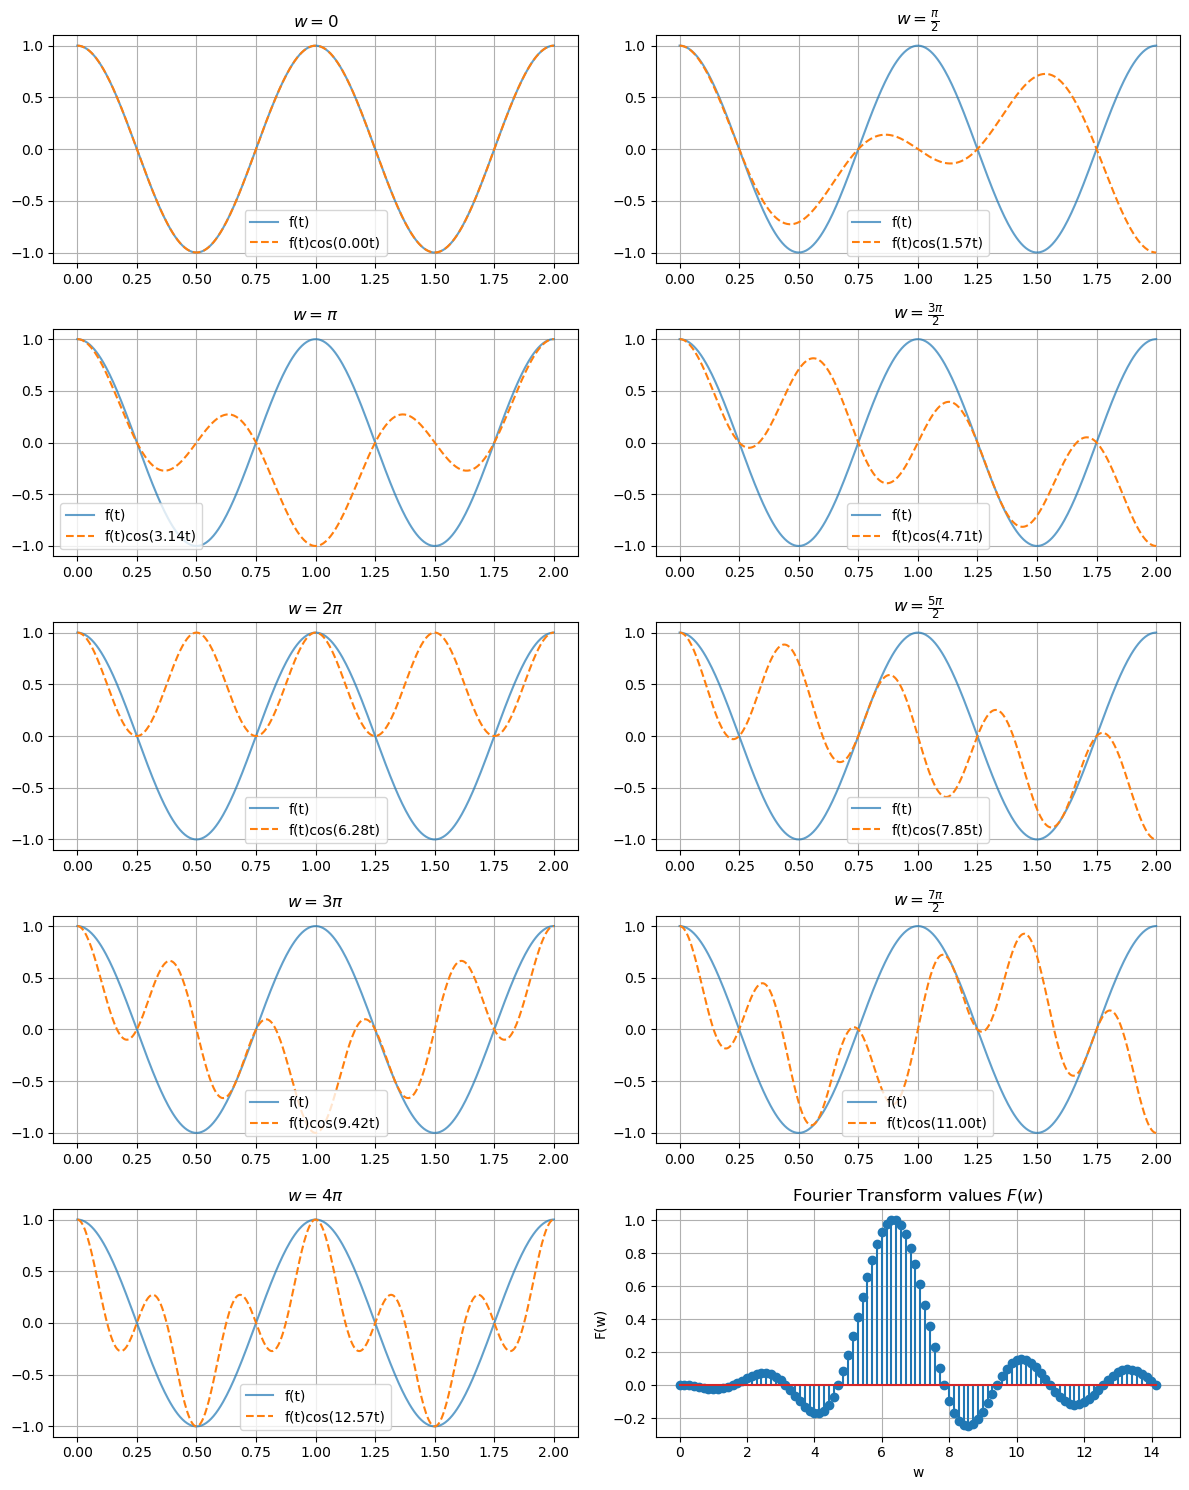

In [3]:
# Define the function f(t) = cos(2*pi*t)
def f(t):
    return np.cos(2*np.pi*t)

# Define a function to compute the real part of the Fourier Transform
def F_real(w, t_values):
    delta_t = t_values[1] - t_values[0]
    return np.sum(f(t_values) * np.cos(w*t_values)) * delta_t

t = np.linspace(0, 2, 400)  # Define time values, e.g., two periods
ws = np.arange(0, 4*np.pi + np.pi/2, np.pi/2)  # Define the range of w values

# Compute Fourier Transform values for all w
F_values = [F_real(w, t) for w in ws]

# Create a 5x2 grid of plots
fig, axs = plt.subplots(5, 2, figsize=(12, 15))

for i, w in enumerate(ws):
    row = i // 2
    col = i % 2

    # Plot original signal
    axs[row, col].plot(t, f(t), label='f(t)', alpha=0.7)
    
    # Plot f(t)*cos(wt) for this w value
    axs[row, col].plot(t, f(t) * np.cos(w*t), label=f'f(t)cos({w:.2f}t)', linestyle='dashed')
    
    # LaTeX formatting for title with simplified fractions for even i values
    if i == 0:
        axs[row, col].set_title(r'$w = 0$')
    elif i == 1:
        axs[row, col].set_title(r'$w = \frac{\pi}{2}$')
    elif i == 2:
        axs[row, col].set_title(r'$w = \pi$')
    elif i % 2 == 0:
        axs[row, col].set_title(r'$w = ' + str(i // 2) + r'\pi$')
    else:
        axs[row,                                                                                                                                                                                                                                                                                                col].set_title(r'$w = \frac{' + str(i) + r'\pi}{2}$')
    axs[row, col].legend()
    axs[row, col].grid(True)

ws = np.linspace(0, 4*np.pi + np.pi/2, 100)  # Define the range of w values
F_values = [F_real(w, t) for w in ws]


# Plot Fourier Transform values in the final subplot
axs[4, 1].stem(ws, F_values, use_line_collection=True)
axs[4, 1].set_title(r'Fourier Transform values $F(w)$')
axs[4, 1].set_xlabel('w')
axs[4, 1].set_ylabel('F(w)')
axs[4, 1].grid(True)
#
plt.tight_layout()
plt.show()


#### Inverse Fourier Transform

The inverse fourier transform is the reverse process, this is takes us from the decomposition into signal components back into the signal. So the value of the signal at time $t$ is given by the integral of the coefficients of the sine and cosine terms, multiplied by the value of the frequency at that point ($e^{iwt}$),

$$f(t)= \frac{1}{2π}\int_{-\infty}^{\infty} F(w) e^{iwt} dw$$

It is worth noting, these two representations are equivalent and contain the same information, just expressed in different forms, either as the signal, which can be decomposed into frequency components or as frequency components which can be recomposed into the signal.

#### Characteristic Function

The characteristic function $\phi_X(t)$ of a random variable $X$ is defined as the expected value of $e^{itX}$, which can be represented as:
$$\phi_X(t) = \mathbb{E}[e^{itX}] = \phi_X(t) = \int_{-\infty}^{\infty} f(x) e^{itx} dx. $$

This is somewhat akin to an inverse fourier transform of the probability density. And can be interpreted as follows,


- Characteristic Function: It provides a time-domain representation of a random variable's distribution. It captures how the distribution would be represented if you were to decompose it into time-varying sinusoids. For most practical purposes in probability theory, you're not thinking about it as a time-domain signal but rather as a function that captures various properties of the random variable's distribution.

- Probability Density Function (pdf): Given our discussion, this represents the frequency-domain description of the random variable's distribution. It captures the "weight" or contribution of various sinusoidal frequencies to the shape or structure of the distribution.

To understand this intuitively:

- If you were to take the characteristic function and ask, "What frequencies are most prominent in constructing this function?", the pdf would give you the answer.
- The peaks in the pdf signify the dominant frequencies, whereas valleys or low points signify frequencies that are not strongly present.
In essence, the pdf is showing you the spectrum of the characteristic function. Peaks in the pdf tell you which frequencies are dominant in the characteristic function.


## Analytic Solution to Temperature Model

$$ \left( \begin{array}{c} dT_t \\ dS_{t} \\ \end{array} \right) = \left( \begin{array}{c} \dot{\mu}(t) + \alpha(\mu(t) - T_{t}) \\ \dot{\sigma}(t) + \beta(\sigma(t) - S_{t}) \\ \end{array} \right) dt + \left( \begin{array}{c} S_{t} & 0 \\ 0 & \chi \cdot \sqrt{2\beta} \\ \end{array} \right) \left( \begin{array}{c} dW^{(1)}_{t} \\ dW^{(2)}_{t} \\ \end{array} \right)$$
$$ S_{0} \sim N(\sigma(0), \chi^{2}) $$

It is fairly easy to show that, even for this time-dependent Ornstein-Ulhenbeck process, $S_{t} \sim N(\sigma(t), \chi^{2})$,

\begin{align*}
    & dS_{t} = \left[\dot{\sigma}(t) + \beta (\sigma(t) - S_{t}) \right] dt + \chi \cdot \sqrt{2 \beta}~dW_{t}, \\
    & dZ_{t} = \left[\beta S_{t} e^{\beta t} + \beta e^{\beta t} \left(\sigma(t) - S_{t}\right) + e^{\beta t} \dot{\sigma}(t) \right] dt + \chi \cdot \sqrt{2 \beta} e^{\beta t} dW_{t}, & (\text{Itô's Lemma, } Z_{t} = S_{t}e^{\beta t}) \\
    & dZ_{t} = \left[\beta e^{\beta t} \sigma(t) + e^{\beta t} \dot{\sigma}(t) \right] dt + \chi \cdot \sqrt{2 \beta} e^{\beta t} dW_{t}, \\
    & \int_{0}^{t} dZ_{s} = Z_{t} - Z_{0} = \beta \int_{0}^{t} e^{\beta s}\sigma(s) ds + \int_{0}^{t} e^{\beta s} \dot{\sigma}(s) ds + \chi\cdot\sqrt{2\beta} \int_{0}^{t} e^{\beta s} dW_{s}, \\
    & Z_{t} - Z_{0} = e^{\beta t} \sigma(t) - \sigma(0) + \chi\cdot\sqrt{2\beta} \int_{0}^{t} e^{\beta s} dW_{s}, \\
    & S_{t} e^{\beta t} = S_{0} + e^{\beta t} \sigma(t) - \sigma(0) + \chi\cdot\sqrt{2\beta} \int_{0}^{t} e^{\beta s} dW_{s}, \\
    & S_{t} = \sigma(t) + e^{-\beta t} (S_{0} - \sigma(0)) + \chi\cdot\sqrt{2\beta} \int_{0}^{t} e^{\beta (s-t)} dW_{s}.
\end{align*}

Considering now the quantity, $\int_{0}^{t} e^{\beta (s-t)} dW_{s}$, as the integrand is deterministic, this is Gaussian, with mean $0$ and variance

\begin{align*}
\mathbb{V}\left[ \int_{0}^{t} e^{\beta (s-t)} dW_{s} \right] &= \int_{0}^{t} \mathbb{E}\left[\left(e^{\beta (s-t)}\right)^{2}\right] ds & \text{(Ito's Isometry)} \\
& = \frac{1}{2\beta} (1 - e^{-2\beta t}) \\
&\implies \chi\cdot\sqrt{2\beta} \int_{0}^{t} e^{\beta (s-t)} dW_{s} \sim N(0, \chi^{2}(1 - e^{-2 \beta t}))\\
&\implies \mathbb{V}[S_{t}] = e^{-2 \beta t} \mathbb{V}[S_{0}] + \chi^{2}(1 - e^{-2 \beta t})\\
 \mathbb{V}[S_{0}] = \chi^{2} &\implies \mathbb{V}[S_{t}] = \chi^{2}.
\end{align*}
We now aim to derive an analytic form of the temperature $T_{t}$ driven by stochastic standard deviation,




### References
    [1]: [A Closed-Form Solution for Options with Stochastic Volatility with Applications to Bond and Currency Options](https://www.jstor.org/stable/2962057).